# Multi-Step timeseries forecasting

여러 time-step의 결과(미래)를 예측해봅시다.
우선 간단한 예시 데이터셋을 생성하겠습니다.

In [ ]:
import numpy as np

In [ ]:
data1 = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
data1

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

3일 동안의 과거 값을 가지고 2일 동안의 미래 값을 예측해보겠습니다.

위의 데이터셋을 이용해 예시를 들자면, [10,20,30]을 가지고 [40,50]을 예측할 수 있게끔 문제를 정의해보겠습니다. 

In [ ]:
# split a univariate sequence into samples
def multi_step_split(sequence, n_evidence, n_future):
	evi, fut = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_evidence
		out_end_ix = end_ix + n_future
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_evi, seq_fut = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		evi.append(seq_evi)
		fut.append(seq_fut)
	return np.array(evi), np.array(fut)

In [ ]:
X,y = multi_step_split(data1,3,2)

for i in range(len(X)):
  print(X[i],y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]
[60 70 80] [ 90 100]
[70 80 90] [100 110]
[ 80  90 100] [110 120]
[ 90 100 110] [120 130]
[100 110 120] [130 140]
[110 120 130] [140 150]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_batch = 1

trainsets = TensorData(x_train, y_train)
trainloader = DataLoader(trainsets, batch_size=n_batch, shuffle=True)

testsets = TensorData(x_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=n_batch, shuffle=False)

inferencesets = TensorData(X,y)
inferenceloader = torch.utils.data.DataLoader(inferencesets, batch_size=n_batch, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self,n_input=0, n_output=0):
    
        super().__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.layer1 = nn.Linear(in_features = n_input, out_features = 100)
        self.layer2 = nn.Linear(in_features = 100, out_features = n_output)
        
    def forward(self, x):
    
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        
        return x

In [ ]:
model = MLP(3,2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for _,(inputs,values) in enumerate(trainloader):
    
    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

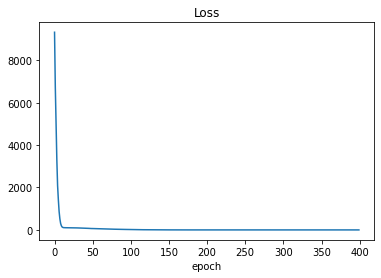

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
x_predict = []
y_label = []
for _,(inputs,values) in enumerate(inferenceloader): # 무작위로 섞인 n_batch개의 데이터가 담긴 배치가 하나씩 들어온다.
  
    inputs = inputs[0,:]
    values = values[0,:]
    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.

    x_predict.append([t.item() for t in outputs])
    y_label.append([t.item() for t in values])

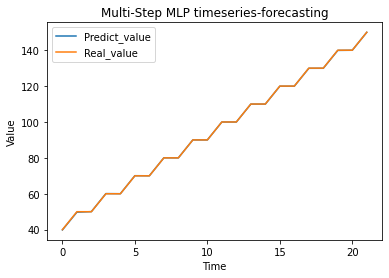

In [ ]:
plt.plot(np.array(x_predict).reshape(-1))
plt.plot(np.array(y_label).reshape(-1))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multi-Step MLP timeseries-forecasting')
plt.legend(['Predict_value', 'Real_value'])

# Multi-Variate timeseries forecasting

마찬가지로 간단한 데이터셋을 생성해 문제를 정의하겠습니다.
3일 동안의 기온, 강수량 값을 가지고 다음날의 해수면 값을 예측해보겠습니다.

아래의 데이터셋을 이용해 예시를 들면, [50,30,20]과 [25,90,40]을 가지고 30을 예측해보겠습니다.

In [ ]:
data1 = np.array([50,30,20,90,40,35,24,16,100,25])
data2 = np.array([25,90,40,20,30,53,99,42,23,191])
data3 = np.array([155,20,50,30,161,42,35,42,193,92])

dataset = np.vstack((data1,data2,data3)).T
dataset

array([[ 50,  25, 155],
       [ 30,  90,  20],
       [ 20,  40,  50],
       [ 90,  20,  30],
       [ 40,  30, 161],
       [ 35,  53,  42],
       [ 24,  99,  35],
       [ 16,  42,  42],
       [100,  23, 193],
       [ 25, 191,  92]])

In [ ]:
# split a multivariate sequence into samples
def multi_variate_split(sequences, n_steps):
	evi, fut = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_evi, seq_fut = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		evi.append(seq_evi)
		fut.append(seq_fut)
	return np.array(evi), np.array(fut)

In [ ]:
X,y = multi_variate_split(dataset,3)

for i in range(len(X)):
  print(X[i],y[i])

[[50 25]
 [30 90]
 [20 40]] 50
[[30 90]
 [20 40]
 [90 20]] 30
[[20 40]
 [90 20]
 [40 30]] 161
[[90 20]
 [40 30]
 [35 53]] 42
[[40 30]
 [35 53]
 [24 99]] 35
[[35 53]
 [24 99]
 [16 42]] 42
[[ 24  99]
 [ 16  42]
 [100  23]] 193
[[ 16  42]
 [100  23]
 [ 25 191]] 92


In [ ]:
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_batch = 1

trainsets = TensorData(x_train, y_train)
trainloader = DataLoader(trainsets, batch_size=n_batch, shuffle=True)

testsets = TensorData(x_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=n_batch, shuffle=False)


inferencesets = TensorData(X,y)
inferenceloader = torch.utils.data.DataLoader(inferencesets, batch_size=n_batch, shuffle=False)

In [ ]:
model = MLP(6,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for _,(inputs,values) in enumerate(trainloader):
    
    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


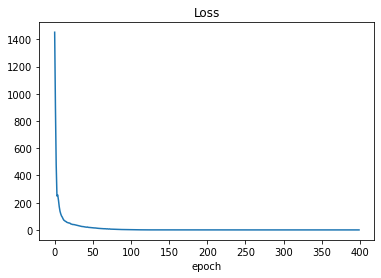

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
x_predict = []
y_label = []
for _,(inputs,values) in enumerate(inferenceloader): # 무작위로 섞인 n_batch개의 데이터가 담긴 배치가 하나씩 들어온다.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.

    x_predict.append([t.item() for t in outputs])
    y_label.append([t.item() for t in values])

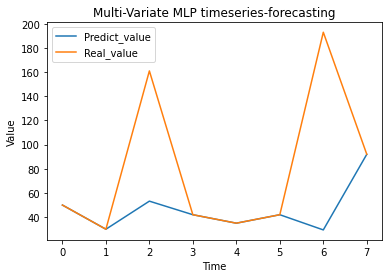

In [ ]:
plt.plot(np.array(x_predict).reshape(-1))
plt.plot(np.array(y_label).reshape(-1))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multi-Variate MLP timeseries-forecasting')
plt.legend(['Predict_value', 'Real_value'])